In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

suicide = pd.read_csv('master.csv',index_col=0,parse_dates=[0])

# Originalmente "País" es la columna de índice, esto crea una columna de índice
suicide = suicide.reset_index()

suicide = suicide[suicide.year != 2016]

# borramos columnas que no necesitamos
del suicide['country-year']         # Redundante
del suicide['HDI for year']         # Mayor numero de valores perdido
del suicide['suicides_no']          # Colapso en suicidios por cada 100 mil habitantes
del suicide['generation']           # Inconsistencia en los datos
del suicide[' gdp_for_year ($) ']   # Se mantiene GDP per capita

# Creamos una nueva variable categórica "Región"
header = ['country',
 'year',
 'sex',
 'age',
 'suicides/100k pop',
 'gdp_per_capita ($)',
 'population',
 'region']

suicide = suicide.reindex(columns = header)        

# Ponemos manualmente todos los diferentes países en una de las 6 regiones.
Europa = ["Albania","Russian Federation","France","Ukraine","Germany","Poland","United Kingdom",
         "Italy","Spain","Hungary","Romania","Belgium","Belarus","Netherlands","Austria",
         "Czech Republic","Sweden","Bulgaria","Finland","Lithuania","Switzerland","Serbia",
         "Portugal","Croatia","Norway","Denmark","Slovakia","Latvia","Greece","Slovenia",
         "Turkey","Estonia","Georgia","Albania","Luxembourg","Armenia","Iceland","Montenegro",
         "Cyprus","Bosnia and Herzegovina","San Marino","Malta","Ireland"]
NorteAmerica = ["United States","Mexico","Canada","Cuba","El Salvador","Puerto Rico",
                "Guatemala","Costa Rica","Nicaragua","Belize","Jamaica"]
Sudamerica = ["Brazil","Colombia", "Chile","Ecuador","Uruguay","Paraguay","Argentina",
                "Panama","Guyana","Suriname"]
OrienteMedio = ["Kazakhstan","Uzbekistan","Kyrgyzstan","Israel","Turkmenistan","Azerbaijan",
              "Kuwait","United Arab Emirates","Qatar","Bahrain","Oman"]
Asia = ["Japan","Republic of Korea", "Thailand", "Sri Lanka","Philippines","New Zealand",
        "Australia","Singapore","Macau","Mongolia"]

# Si el país pertenece a una región, asignamos la observación a la región
for i in range(0,len(suicide)):
    if suicide.iloc[i,0] in Europa:
        suicide.iloc[i,7] = "Europa"
    elif suicide.iloc[i,0] in NorteAmerica:
        suicide.iloc[i,7] = "Norte America"
    elif suicide.iloc[i,0] in Sudamerica:
        suicide.iloc[i,7] = "Sudamerica"
    elif suicide.iloc[i,0] in OrienteMedio:
        suicide.iloc[i,7] = "Oriente Medio"
    elif suicide.iloc[i,0] in Asia:
        suicide.iloc[i,7] = "Asia"
    else:
        suicide.iloc[i,7] = "Pais Insular"

# Ahora que no necesitamos "país", lo eliminamos.
del suicide['country']

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    6.1s finished


El error de la raíz cuadrada media para el CV establecido en un modelo de regresión de árbol de decisión es: 11.900933637225565
El error de la raíz cuadrada media para el conjunto de CV en un modelo de regresión lineal es: 15.432719558866795
El árbol de decisión es mejor wr.r. Los datos de validación cruzada.
El error de raíz media cuadrática para el conjunto de pruebas en un modelo de regresión de árbol de decisión es: 11.87726274766188


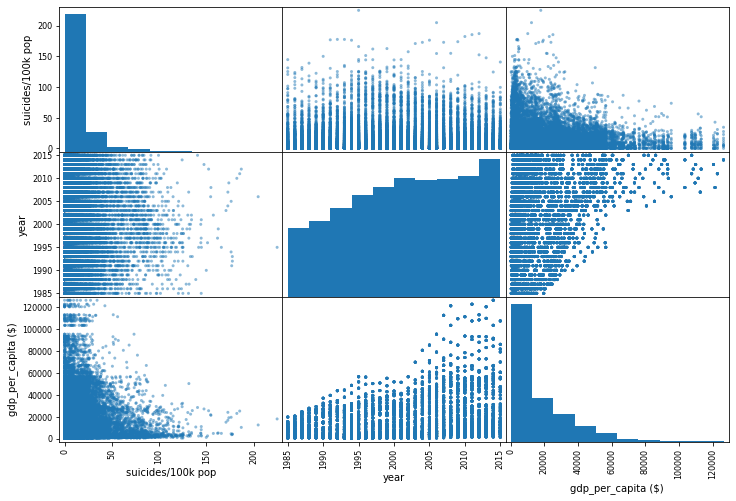

In [2]:
# Recopilamos nuestras variables categóricas para One Hot Encoding
suicide_cat = suicide[['sex','age','region', 'year']]
one_hot_data = pd.get_dummies(suicide_cat)

# Combinamos los datos de nuevo
population = suicide['population']
gdp_per_cap = suicide['gdp_per_capita ($)']
suicide_per_100k = suicide['suicides/100k pop']
data = pd.concat([population, gdp_per_cap, one_hot_data], axis=1)

# Ahora que los datos están limpios, entrenamos algunos modelos.
# Hacemos un DecisionTreeRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, suicide_per_100k, test_size=0.4, random_state=42)

# Un conjunto de validación cruzada y un conjunto de prueba.
X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Usamos un GridSearchCV para buscar los mejores hiperparámetros. 
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

params = {'max_leaf_nodes': list(range(93,95)), 'min_samples_split': list(range(6,8)), 
          'min_samples_leaf':list(range(2,4))}    
grid_search_cv = GridSearchCV(DecisionTreeRegressor(random_state=42),
                              params, n_jobs=-1, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error

y_pred = grid_search_cv.predict(X_cv)
tree_reg_mse = mean_squared_error(y_cv, y_pred)
tree_reg_rmse = np.sqrt(tree_reg_mse)
print("El error de la raíz cuadrada media para el CV establecido en un modelo de regresión de árbol de decisión es:",
      tree_reg_rmse)


# Basado en los diagramas de dispersión a continuación, no parece una relación lineal, 
# y por lo tanto la regresión lineal probablemente no produciría un buen modelo.

from pandas.plotting import scatter_matrix
attributes = ['suicides/100k pop','year','gdp_per_capita ($)']
scatter_matrix(suicide[attributes], figsize=(12,8))

# Realizamos una regresión lineal como prueba
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

y_pred_lin_reg = lin_reg.predict(X_cv)
lin_reg_mse = mean_squared_error(y_cv, y_pred_lin_reg)
lin_reg_rmse = np.sqrt(lin_reg_mse)
print("El error de la raíz cuadrada media para el conjunto de CV en un modelo de regresión lineal es:",lin_reg_rmse)

# El árbol de decisión es mejor wr.r. Los datos de validación cruzada.
print("El árbol de decisión es mejor wr.r. Los datos de validación cruzada.")

# Obtenemos nuestro RMSE para el conjunto de prueba
y_pred = grid_search_cv.predict(X_test)
tree_reg_mse = mean_squared_error(y_test, y_pred)
tree_reg_rmse = np.sqrt(tree_reg_mse)
print("El error de raíz media cuadrática para el conjunto de pruebas en un modelo de regresión de árbol de decisión es:",
      tree_reg_rmse)